In [1]:
import sys
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [2]:
dirs = os.listdir("camera_cal/")
NX = 9            #棋盘格每行角点数
NY = 6            #
dirs

['calibration10.jpg',
 'calibration20.jpg',
 'calibration16.jpg',
 'calibration4.jpg',
 'calibration6.jpg',
 'calibration11.jpg',
 'calibration15.jpg',
 'calibration19.jpg',
 'calibration14.jpg',
 'calibration9.jpg',
 'calibration7.jpg',
 'calibration8.jpg',
 'calibration1.jpg',
 'calibration5.jpg',
 'calibration18.jpg',
 'calibration12.jpg',
 'calibration3.jpg',
 'calibration13.jpg',
 'calibration17.jpg',
 'calibration2.jpg']

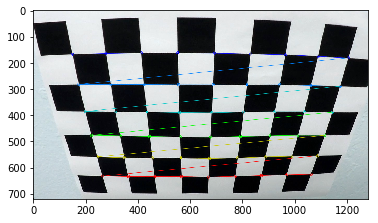

In [3]:
objpoints = []                                #真实环境对应点组
imgpoints = []                                #对应图片中的点组
objp = np.zeros((NX*NY,3), np.float32)        #根据提供的棋盘格的个数分布
objp[:,:2] = np.mgrid[0:NX,0:NY].T.reshape(-1,2)

for file in dirs:                             #遍历参考的所有图片
    img = cv2.imread("camera_cal/"+file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (NX, NY), None)
    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        cv2.drawChessboardCorners(img, (NX, NY), corners, ret)
        plt.imshow(img)
    

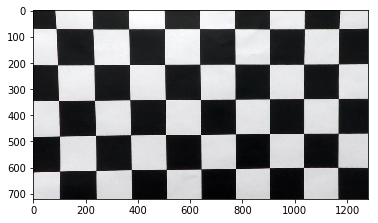

In [4]:
img_test = cv2.imread("camera_cal/calibration1.jpg")
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
dst = cv2.undistort(img_test, mtx, dist, None, mtx)
plt.imshow(dst)

In [5]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
   # undist = np.copy(img)  # Delete this line
    return dst

In [6]:
dirs_test = os.listdir("test_images/")
dirs_test

['straight_lines2.jpg',
 'straight_lines1.jpg',
 'test1.jpg',
 'test5.jpg',
 'test2.jpg',
 'test4.jpg',
 'test6.jpg',
 'test3.jpg']

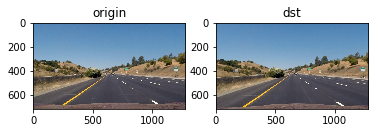

In [7]:
img_test1 = cv2.imread("test_images/straight_lines1.jpg")
img_test1 = cv2.cvtColor(img_test1, cv2.COLOR_BGR2RGB)
dst_undistort = cal_undistort(img_test1, objpoints, imgpoints)

plt.subplot(1,2,1)
plt.title('origin')
plt.imshow(img_test1)

plt.subplot(1,2,2)
plt.title('dst')
plt.imshow(dst_undistort)

下一步做perception transferform，

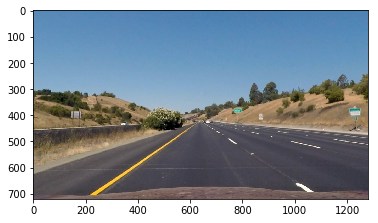

In [8]:
plt.imshow(dst_undistort)

，首先打印出example中的车道线非常正的图片，在图片上的左右车道线，各取2个点，共四个点坐标([260,678],[595,450],[684,450],[1041,678])梯形，而在真实环境下应对应的四个点为一个矩形，故可假设真实环境对应的点为[300,720],[300,0],[900,0],[900,720]

In [9]:
src = np.float32([[260,678],[595,450],[684,450],[1041,678]])
dst = np.float32([[300,720],[300,0],[900,0],[900,720]])

In [10]:
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

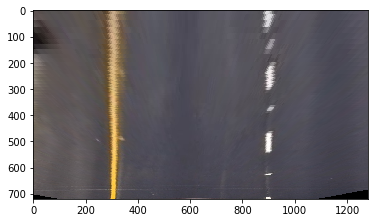

In [11]:
perspective_img = warper(dst_undistort, src, dst)
plt.imshow(perspective_img)

### 车道线特征提取
根据培训资料可知，有多种方法可提取相关特征，下面分别采用每种提取单独进行处理，然后选择最为合适的或者融合合适的几种方法。
包括：
1.采用梯度：由于车道线主要是垂直的，因此采用sobelx索贝尔算子；
2.采用HLS色彩空间：由于受天气、遮挡、阴影等，图像明亮不定，导致灰度梯度等无法区分真实车道线还是阴影，采用HLS空间的S通道表示颜色饱和度，不关心亮度，因此可以很好提取特定颜色深度；

## sobelx提取梯度

In [12]:
def abs_sobelx_thresh(img,thresh_min=0,thresh_max=255,sobel_kernel=3):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(abs_sobelx*255/np.max(abs_sobelx))
    binary_output = np.zeros_like(abs_sobelx)
    binary_output[(abs_sobelx>thresh_min)&(abs_sobelx<=thresh_max)] = 1
    return binary_output

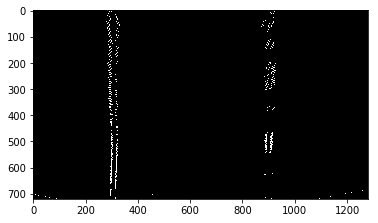

In [13]:
sobelx_img_input = np.copy(perspective_img)
sobelx_img_output = abs_sobelx_thresh(sobelx_img_input,thresh_min=80,thresh_max=170,sobel_kernel=8)
plt.imshow(sobelx_img_output, cmap='gray')

## HLS色彩空间提取颜色和饱和度

In [14]:
def hls_select_s_thresh(img,s_thresh_min,s_thresh_max):
    HLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    S=HLS[:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S>s_thresh_min)&(S<=s_thresh_max)] = 1
    return binary_output

### H提取，将黄色提取

In [15]:
def hls_select_h_thresh(img,yellow_thresh_min,yellow_thresh_max):
    HLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    H=HLS[:,:,0]
    binary_output = np.zeros_like(H)
    binary_output[(H>yellow_thresh_min)&(H<=yellow_thresh_max)] = 1
    return binary_output

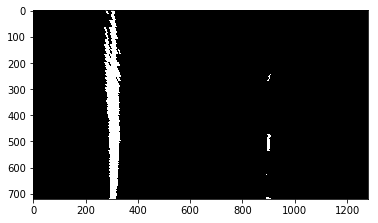

In [16]:
s_img_input = np.copy(perspective_img)
s_img_output = hls_select_s_thresh(s_img_input,80,255)
plt.imshow(s_img_output, cmap='gray')

# 两种车道线特征合并

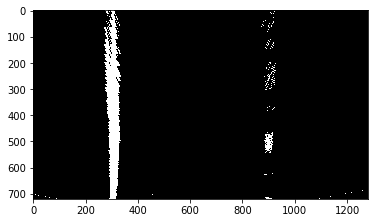

In [17]:
lane_output=np.zeros_like(s_img_output)
lane_output[(s_img_output==1)|(sobelx_img_output==1)]=1
plt.imshow(lane_output, cmap='gray')

# 测试其他例图

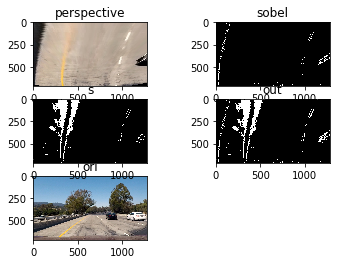

In [18]:
img_test = cv2.imread("test_images/test1.jpg")
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
plt.subplot(3,2,5)
plt.title('ori')
plt.imshow(img_test)

dst_undistort = cal_undistort(img_test, objpoints, imgpoints)
perspective_img = warper(dst_undistort, src, dst)

plt.subplot(3,2,1)
plt.title('perspective')
plt.imshow(perspective_img)

sobelx_img_input = np.copy(perspective_img)
sobelx_img_output = abs_sobelx_thresh(sobelx_img_input,thresh_min=50,thresh_max=255,sobel_kernel=8)

plt.subplot(3,2,2)
plt.title('sobel')
plt.imshow(sobelx_img_output, cmap='gray')

s_img_input = np.copy(perspective_img)
s_img_output = hls_select_s_thresh(s_img_input,80,120)

plt.subplot(3,2,3)
plt.title('s')
plt.imshow(s_img_output, cmap='gray')

lane_output=np.zeros_like(s_img_output)
lane_output[(s_img_output==1)|(sobelx_img_output==1)]=1
plt.subplot(3,2,4)
plt.title('out')
plt.imshow(lane_output, cmap='gray')

通过测试，发现test1和test4效果不好，尤其黄色的车道线，效果不好，因此需要考虑增加黄色的检测

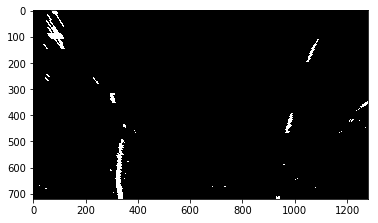

In [19]:
h_img_input = np.copy(perspective_img)
h_img_output = hls_select_h_thresh(h_img_input,60,100)
plt.imshow(h_img_output, cmap='gray')

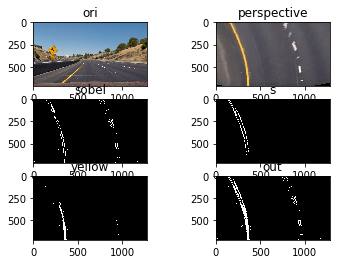

In [20]:
img_test = cv2.imread("test_images/test2.jpg")
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
plt.subplot(3,2,1)
plt.title('ori')
plt.imshow(img_test)

dst_undistort = cal_undistort(img_test, objpoints, imgpoints)
perspective_img = warper(dst_undistort, src, dst)

plt.subplot(3,2,2)
plt.title('perspective')
plt.imshow(perspective_img)

sobelx_img_input = np.copy(perspective_img)
sobelx_img_output = abs_sobelx_thresh(sobelx_img_input,thresh_min=50,thresh_max=255,sobel_kernel=8)

plt.subplot(3,2,3)
plt.title('sobel')
plt.imshow(sobelx_img_output, cmap='gray')

s_img_input = np.copy(perspective_img)
s_img_output = hls_select_s_thresh(s_img_input,80,120)

plt.subplot(3,2,4)
plt.title('s')
plt.imshow(s_img_output, cmap='gray')

h_img_input = np.copy(perspective_img)
h_img_output = hls_select_h_thresh(h_img_input,80,100)

plt.subplot(3,2,5)
plt.title('yellow')
plt.imshow(h_img_output, cmap='gray')

lane_output=np.zeros_like(s_img_output)
lane_output[(s_img_output==1)|(sobelx_img_output==1)|(h_img_output==1)]=1
plt.subplot(3,2,6)
plt.title('out')
plt.imshow(lane_output, cmap='gray')

有一定改善但效果不明显，进行封装成function

In [21]:
def img_pre(img,objpoints,imgpoints,src,dst):
    img_test = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dst_undistort = cal_undistort(img_test, objpoints, imgpoints)
    perspective_img = warper(dst_undistort, src, dst)
    
    sobelx_img_input = np.copy(perspective_img)
    sobelx_img_output = abs_sobelx_thresh(sobelx_img_input,thresh_min=50,thresh_max=255,sobel_kernel=8)

    s_img_input = np.copy(perspective_img)
    s_img_output = hls_select_s_thresh(s_img_input,80,120)

    h_img_input = np.copy(perspective_img)
    h_img_output = hls_select_h_thresh(h_img_input,80,100)

    lane_output=np.zeros_like(s_img_output)
    lane_output[(s_img_output==1)|(sobelx_img_output==1)|(h_img_output==1)]=1
    return lane_output,dst_undistort

# 采用滑动窗口查找车道线主要经过的点

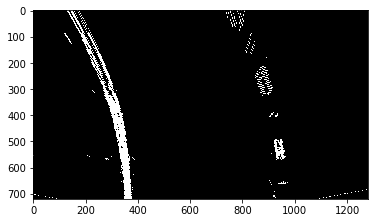

In [22]:
img_test = cv2.imread("test_images/test2.jpg")
img_out,dst_undistort = img_pre(img_test,objpoints,imgpoints,src,dst)
plt.imshow(img_out, cmap='gray')

采用滑窗思想，应当首先找到离车最近附近即图像底部的车道线像素，然后向上滑窗，采用图像下面的一半进行垂直方向统计，如此可找到车道线底部的起始位置

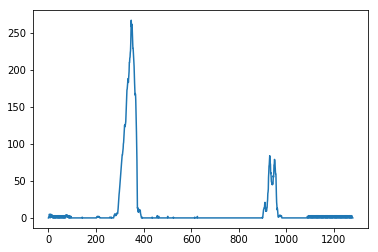

In [23]:
histogram = np.sum(img_out[img_out.shape[0]//2:,:],axis=0)
plt.plot(histogram)

In [24]:
mid_index_x = img_out.shape[1]//2
left_curr = np.argmax(histogram[:mid_index_x])
right_curr = np.argmax(histogram[mid_index_x:]) + mid_index_x
nwindows=9
margin = 100 
minpix = 50
windows_height = img_out.shape[0]//nwindows

nonzero = img_out.nonzero()   #提取所有非0的点坐标集合
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])


left_lanes_point =[]
right_lanes_point =[]


count=0
for index in range(nwindows):
    window_down = np.int(img_out.shape[0]-index*windows_height)
    window_up = np.int(img_out.shape[0]-(index+1)*windows_height)
    window_left_bound_left = left_curr - margin
    window_right_bound_left = left_curr + margin
    window_left_bound_right = right_curr - margin
    window_right_bound_right = right_curr + margin
    left_points_in_window_xindex = ((nonzerox>window_left_bound_left)&(nonzerox<window_right_bound_left)&
                                    (nonzeroy<=window_down)&(nonzeroy>window_up)).nonzero()[0]
    right_points_in_window_xindex = ((nonzerox>window_left_bound_right)&(nonzerox<window_right_bound_right)&
                                    (nonzeroy<=window_down)&(nonzeroy>window_up)).nonzero()[0]
    
    if(len(left_points_in_window_xindex) >minpix):
        left_curr = np.int(np.sum(nonzerox[left_points_in_window_xindex])/len(left_points_in_window_xindex))
    if(len(right_points_in_window_xindex) >minpix):
        right_curr =  np.int(np.sum(nonzerox[right_points_in_window_xindex])/len(right_points_in_window_xindex))
        
    left_lanes_point.append(left_points_in_window_xindex)
    right_lanes_point.append(right_points_in_window_xindex)
    count=count+1
count

9

In [25]:
try:
    left_lanes_point = np.concatenate(left_lanes_point)
    right_lanes_point = np.concatenate(right_lanes_point)
except ValueError:
    pass

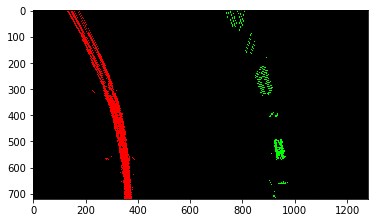

In [26]:
leftx = nonzerox[left_lanes_point]
lefty = nonzeroy[left_lanes_point]

rightx = nonzerox[right_lanes_point]
righty = nonzeroy[right_lanes_point]


outimg_lane = np.dstack((img_out,img_out,img_out))
outimg_lane[lefty,leftx] = [255,0,0]
outimg_lane[righty,rightx] = [0,255,0]
plt.imshow(outimg_lane)

## 封装成函数

In [27]:
def slide_window_lane_points(img_out):
    histogram = np.sum(img_out[img_out.shape[0]//2:,:],axis=0)
    mid_index_x = img_out.shape[1]//2
    left_curr = np.argmax(histogram[:mid_index_x])
    right_curr = np.argmax(histogram[mid_index_x:]) + mid_index_x
    nwindows=9
    margin = 100 
    minpix = 50
    windows_height = img_out.shape[0]//nwindows

    nonzero = img_out.nonzero()   #提取所有非0的点坐标集合
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])


    left_lanes_point =[]
    right_lanes_point =[]


    count=0
    for index in range(nwindows):
        window_down = np.int(img_out.shape[0]-index*windows_height)
        window_up = np.int(img_out.shape[0]-(index+1)*windows_height)
        window_left_bound_left = left_curr - margin
        window_right_bound_left = left_curr + margin
        window_left_bound_right = right_curr - margin
        window_right_bound_right = right_curr + margin
        left_points_in_window_xindex = ((nonzerox>window_left_bound_left)&(nonzerox<window_right_bound_left)&
                                        (nonzeroy<=window_down)&(nonzeroy>window_up)).nonzero()[0]
        right_points_in_window_xindex = ((nonzerox>window_left_bound_right)&(nonzerox<window_right_bound_right)&
                                         (nonzeroy<=window_down)&(nonzeroy>window_up)).nonzero()[0]
    
        if(len(left_points_in_window_xindex) >minpix):
            left_curr = np.int(np.sum(nonzerox[left_points_in_window_xindex])/len(left_points_in_window_xindex))
        if(len(right_points_in_window_xindex) >minpix):
            right_curr =  np.int(np.sum(nonzerox[right_points_in_window_xindex])/len(right_points_in_window_xindex))
        
        left_lanes_point.append(left_points_in_window_xindex)
        right_lanes_point.append(right_points_in_window_xindex)
    try:
        left_lanes_point = np.concatenate(left_lanes_point)
        right_lanes_point = np.concatenate(right_lanes_point)
    except ValueError:
        pass
    leftx = nonzerox[left_lanes_point]
    lefty = nonzeroy[left_lanes_point]

    rightx = nonzerox[right_lanes_point]
    righty = nonzeroy[right_lanes_point]
    return leftx,lefty,rightx,righty

# 测试封装的函数

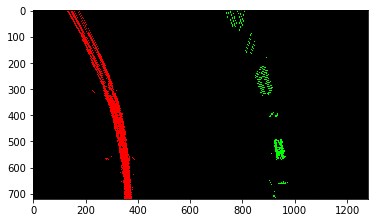

In [28]:
img_test = cv2.imread("test_images/test2.jpg")
img_out,dst_undistort= img_pre(img_test,objpoints,imgpoints,src,dst)
leftx,lefty,rightx,righty = slide_window_lane_points(img_out)
outimg_lane = np.dstack((img_out,img_out,img_out))
outimg_lane[lefty,leftx] = [255,0,0]
outimg_lane[righty,rightx] = [0,255,0]
plt.imshow(outimg_lane)

# 采用多项式拟合，根据教程可知，2次多项式即可，然后绘制车道线

-0.00041925928901833645,0.5990172737892129,145.9792785092922


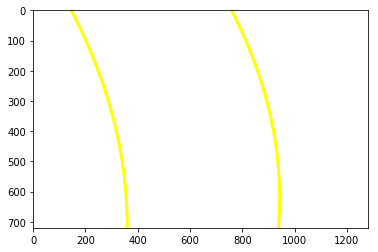

In [29]:
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
ploty = np.linspace(0, img_out.shape[0]-1, img_out.shape[0])
print('{},{},{}'.format(left_fit[0],left_fit[1],left_fit[2]))
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
plt.plot(left_fitx, ploty, color='yellow', linewidth=3.0)
plt.plot(right_fitx, ploty, color='yellow',  linewidth=3.0)
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

## 封装成函数再次测试

In [30]:
def find_poly_points(img,leftx,lefty,rightx,righty):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fit,right_fit,left_fitx,right_fitx,ploty

# 测试找到车道线整个功能

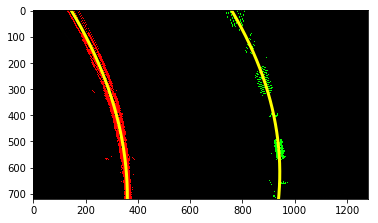

In [31]:
img_test = cv2.imread("test_images/test2.jpg")
img_out,dst_undistort = img_pre(img_test,objpoints,imgpoints,src,dst)
leftx,lefty,rightx,righty = slide_window_lane_points(img_out)

left_fit,right_fit,left_fitx,right_fitx,ploty = find_poly_points(img_out,leftx,lefty,rightx,righty)

outimg_lane = np.dstack((img_out,img_out,img_out))
outimg_lane[lefty,leftx] = [255,0,0]
outimg_lane[righty,rightx] = [0,255,0]
plt.imshow(outimg_lane)
plt.plot(left_fitx, ploty, color='yellow', linewidth=3.0)
plt.plot(right_fitx, ploty, color='yellow',  linewidth=3.0)
plt.show()

## 采用前帧的车道线结果近似下帧车道线的有效范围
采用上面的滑窗方法，相当于遍历整个图像，如果是一张单独照片，需要如此方法，但是由于汽车观测的视频相邻的两帧照片区别不大，因此车道线的位置不会有太大的变化。可以采用如此可以用上一帧的计算的车道线多项式，然后直接扩展出有效车道线范围内，进行查找新的一帧车道线的点。因此可以将上面的滑窗处理进行一定修正。

In [32]:
def continue_find_lane_points(img_out,left_fit,right_fit,ploty):
    margin = 100 

    nonzero = img_out.nonzero()   #提取所有非0的点坐标集合
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_points_in_window_xindex = ((nonzerox>(left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy+left_fit[2]- margin))&
                                    (nonzerox<=( left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy+left_fit[2]+ margin)))
    right_points_in_window_xindex = ((nonzerox>( right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy+right_fit[2]- margin))&
                                     (nonzerox<=( right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy+right_fit[2]+ margin)))

    leftx = nonzerox[left_points_in_window_xindex]
    lefty = nonzeroy[left_points_in_window_xindex]

    rightx = nonzerox[right_points_in_window_xindex]
    righty = nonzeroy[right_points_in_window_xindex]
    return leftx,lefty,rightx,righty

使用一张测试图片，模拟前后两帧图片，测试车道线检测

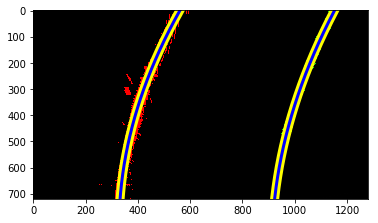

[546 547 552 ... 340 372 379]
[1131 1132 1133 ...  918  919  920]


In [33]:
img_test = cv2.imread("test_images/test3.jpg")
img_out,dst_undistort = img_pre(img_test,objpoints,imgpoints,src,dst)
leftx,lefty,rightx,righty = slide_window_lane_points(img_out)
left_fit,right_fit,left_fitx,right_fitx,ploty = find_poly_points(img_out,leftx,lefty,rightx,righty)


leftx_n,lefty_n,rightx_n,righty_n = continue_find_lane_points(img_out,left_fit,right_fit,ploty)
left_fit_n,right_fit_n,left_fitx_n,right_fitx_n,ploty_n = find_poly_points(img_out,leftx_n,lefty_n,rightx_n,righty_n)


outimg_lane = np.dstack((img_out,img_out,img_out))
outimg_lane[lefty_n,leftx_n] = [255,0,0]
outimg_lane[righty_n,rightx_n] = [0,255,0]
plt.imshow(outimg_lane)

plt.plot(left_fitx, ploty_n, color='yellow', linewidth=9.0)
plt.plot(right_fitx, ploty_n, color='yellow',  linewidth=9.0)
plt.plot(left_fitx_n, ploty_n, color='blue', linewidth=3.0)
plt.plot(right_fitx_n, ploty_n, color='blue',  linewidth=3.0)
plt.show()
print(leftx_n)
print(rightx_n)

# 计算车道线曲率和汽车偏移量

## 曲率
由于车道线采用多项式拟合，因此可根据多项式表达式，求出其曲率。
其多项式为
$ f(y) = Ay^2+By+C\text {，多项式} $。

则曲率为
$ R = \frac{[1+(\frac{dx}{dy})^2]^3/2}{|\frac{d^2x}{dy^2}|}\text {，曲率} $。

化简可得
$ R = \frac{[1+(2Ay + B)^2]^3/2}{|2A|}\text {，曲率} $。

其中y应当取图像最底部的值，因为离车最近，才是汽车目前所在位置的车道线曲率，其中y=img.shape[0]

由于目前计算的曲率是以图片像素单位计算的，但在真实环境下的曲率应当根据像素对应实际对应的距离进行换算。从上图中实际车道线的宽度和长度，以及参考教学课件可知。可近似认为车道宽度为3.7m，对应像素个数约为550; 车道长度为30m，对应车道线为720像素点。应将图片中车道线上点像素坐标转换为真实坐标，然后进行曲线拟合，和曲率计算；

## 偏移量
由于假设摄像机安装位置在汽车中心，因此图像的中心线则为汽车中心，而图像中心距离左右车道线中心的位置则为汽车偏移量。



In [34]:
def get_curvture(img,leftx,lefty,rightx,righty):
    ym_per_pix = 30/700           #每个像素表示真实纵向距离单位m
    xm_per_pix = 3.7/550          #每个像素表示真实横向距离单位m
     
    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)        #用真实坐标进行拟合多项式
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])                #计算多项式的每一个点  
    
    y_base = img.shape[0]*ym_per_pix                                    #计算离车最近的真实纵坐标
    left_curvture = ((1+(2*left_fit[0]*y_base+2*left_fit[1])**2)**(3/2))/np.absolute(2*left_fit[0])
    right_curvture = ((1+(2*right_fit[0]*y_base+2*right_fit[1])**2)**(3/2))/np.absolute(2*right_fit[0])
    
    left_fitx = left_fit[0]*y_base**2 + left_fit[1]*y_base + left_fit[2]     #计算左右车道线离车最近的横向真实坐标
    right_fitx = right_fit[0]*y_base**2 + right_fit[1]*y_base + right_fit[2]
    
    offset = img.shape[1]/2*xm_per_pix - (left_fitx+right_fitx)/2       #计算汽车与车道线的偏移
    return left_curvture,right_curvture,offset

## 测试曲率和车道偏移量获取

In [35]:
left_curvture,right_curvture,offset=get_curvture(img_out,leftx,lefty,rightx,righty)
print(left_curvture)
print(right_curvture)
print(offset)

410.6756886112747
484.2372737746763
0.08363313300084574


# 车道线检测的最后一步，应当将检测出的车道线还原至原观测角度方向

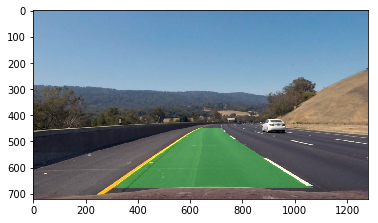

In [36]:
warp_zero = np.zeros_like(img_out).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))
cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
newwarp = warper(color_warp, dst, src)
result = cv2.addWeighted(dst_undistort, 1, newwarp, 0.3, 0)
plt.imshow(result)

## 函数封装

In [37]:
def ori_line_combine(img_pre,img_ori,left_fitx,right_fitx,ploty):
    warp_zero = np.zeros_like(img_pre).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    newwarp = warper(color_warp, dst, src)
    result = cv2.addWeighted(img_ori, 1, newwarp, 0.3, 0)
    return result

def line_pipline(img):
    #src = np.float32([[260,678],[595,450],[684,450],[1041,678]])
    #dst = np.float32([[300,720],[300,0],[900,0],[900,720]])   
    #objpoints,imgpoints 为全局变量
    img_out,dst_undistort = img_pre(img,objpoints,imgpoints,src,dst)
    leftx,lefty,rightx,righty = slide_window_lane_points(img_out)
    left_fit,right_fit,left_fitx,right_fitx,ploty = find_poly_points(img_out,leftx,lefty,rightx,righty)
    left_curvture,right_curvture,offset=get_curvture(img_out,leftx,lefty,rightx,righty)
    result = ori_line_combine(img_out,dst_undistort,left_fitx,right_fitx,ploty)
    return result,left_fit,right_fit,ploty,left_curvture,right_curvture,offset



# 整个流程测试

329.86737277897527
288.6296884323913
-0.06028286906293712


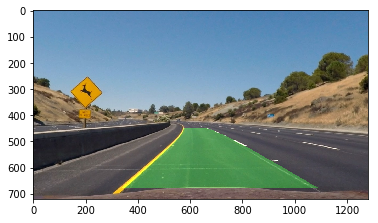

In [38]:
img_test = cv2.imread("test_images/test2.jpg")
# img_out,dst_undistort = img_pre(img_test,objpoints,imgpoints,src,dst)
# leftx,lefty,rightx,righty = slide_window_lane_points(img_out)
# left_fit,right_fit,left_fitx,right_fitx,ploty = find_poly_points(img_out,leftx,lefty,rightx,righty)
# #left_curvture,right_curvture=get_curvture(img_out,left_fit,right_fit)
# result = ori_line_combine(img_out,dst_undistort,left_fitx,right_fitx,ploty)
result,left_fit,right_fit,ploty,left_curvture,right_curvture,offset=line_pipline(img_test)
plt.imshow(result)
print(left_curvture)
print(right_curvture)
print(offset)
#print('left_curvture:{},right_curvture:{}'.format(left_curvture,right_curvture))

# 测试整个test_images的图片并将结果输出至output_images文件夹内

In [39]:
test_dirs = os.listdir("test_images/")
for file in test_dirs:                             #遍历参考的所有图片
    img_test = cv2.imread("test_images/"+file)
    result,left_fit,right_fit,ploty,left_curvture,right_curvture,offset= line_pipline(img_test)
    mpimg.imsave("output_images/"+file,result)

# 测试一个视频实时检测车道线，并且后续帧图像可采用前一帧结果检测有效范围

In [40]:
def line_pipline_continue(img,left_fit,right_fit,ploty):
    img_out,dst_undistort = img_pre(img,objpoints,imgpoints,src,dst)
    leftx,lefty,rightx,righty = continue_find_lane_points(img_out,left_fit,right_fit,ploty)
    left_fit,right_fit,left_fitx,right_fitx,ploty = find_poly_points(img_out,leftx,lefty,rightx,righty)
    left_curvture,right_curvture,offset=get_curvture(img_out,leftx,lefty,rightx,righty)
    result = ori_line_combine(img_out,dst_undistort,left_fitx,right_fitx,ploty)
    return result,left_fit,right_fit,ploty,left_curvture,right_curvture,offset


In [41]:
project_video_output = 'output_images/project_video.mp4'


#capture = cv2.CaptureFromFile('project_video.mp4')
cap = cv2.VideoCapture('project_video.mp4')

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

fps = int(cap.get(5))
print(fps)
codec = cv2.VideoWriter_fourcc(*'MJPG')
#writer=cv.CreateVideoWriter("output_images/project_video.mp4", int(codec), int(fps), (width,height), 1) #Create writer with same parameters
 

out = cv2.VideoWriter('output_images/project_video.mp4', int(codec), int(fps), (frame_width,frame_height),1)
    
    
    

first_flag = 1
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if first_flag == 1:
            first_flag = 0
            result,left_fit,right_fit,ploty,left_curvture,right_curvture,offset= line_pipline(img)
        else:
            result,left_fit,right_fit,ploty,left_curvture,right_curvture,offset= line_pipline_continue(img,left_fit,right_fit,ploty)
    
        img_out=cv2.putText(result, "left_curvture="+str(left_curvture ), (int(200),int(50)), cv2.FONT_HERSHEY_COMPLEX_SMALL,1.8, (0, 255, 255))
        img_out=cv2.putText(img_out, "right_curvture="+str(right_curvture ), (int(200),int(100)), cv2.FONT_HERSHEY_COMPLEX_SMALL,1.8, (0, 255, 255))
        img_out=cv2.putText(img_out, "offset="+str(offset ), (int(200),int(150)), cv2.FONT_HERSHEY_COMPLEX_SMALL,1.8, (0, 255, 255))
        cv2.imshow('frame',img_out)
        out.write(result)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break;

 
cap.release()
out.release()
cv2.destroyAllWindows()

25
